In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas(desc='apply')
import dill
import os
import sys
import re
import matplotlib.pyplot as plt

from sklearn import base
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

%matplotlib inline

In [2]:
class TextPreProcess(base.BaseEstimator, base.TransformerMixin):
    """
    Input  : document list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    
    def __init__(self, ignore):
        self.en_stop = set(stopwords.words('english')) # English stop words list
        self.tokenizer = RegexpTokenizer(r'[a-z]+&?[a-z]+')
        self.lemmatizer = WordNetLemmatizer()
        self.replace = ignore
    
    def _process(self, text):
        raw = text.lower()
        for key, val in self.replace.items():
            raw = re.sub(key, val, raw)
        tokens = self.tokenizer.tokenize(raw)
        stopped_tokens = [i for i in tokens if not i in self.en_stop]
        lemma_tokens = [self.lemmatizer.lemmatize(i) for i in stopped_tokens]
        output = ' '.join(lemma_tokens)
        return output
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        output = [self._process(text) for text in X]
        return output
    
def _iter_titles(files):
    for file in tqdm(files, desc='feathers'):
        df = pd.read_feather(file, columns=['title', 'region'])
        df = df[df['region'] != 'PR']
        for title in tqdm(df['title']):
            yield title
    
def train_model(files, transformer, estimator, classes):
    for file in tqdm(files, desc='feathers'):
        df = pd.read_feather(file, columns=['title', 'region'])
        df = df[df['region'] != 'PR']
        X = transformer.transform(df['title'])
        estimator.partial_fit(X, df['region'], classes=classes)
    return estimator

folder = 'cleaned_cache'
files = [os.path.join(folder, 'data_{}.feather'.format(i)) for i in range(len(os.listdir(folder)))]

## Downsampled data

In [47]:
df = pd.read_feather('grouped/downsampled.feather', columns=['title', 'region'])

ignore = pd.read_feather('other_data/ignore.feather')
ignore_dict = ignore.set_index('regex').to_dict()['sub']

weights = pd.read_feather('other_data/census.feather', columns=['region', 'weight'])
weights.set_index('region', inplace=True)
weights.sort_index(inplace=True)

In [59]:
tfv = TfidfVectorizer(sublinear_tf=True, min_df=10, ngram_range=(1,2), norm='l2')
nb = MultinomialNB(alpha=1, class_prior=weights['weight'].tolist())

X = tfv.fit_transform(df['title'])
nb.fit(X, df['region'])

pipe = Pipeline([('clean', TextPreProcess(ignore=ignore_dict)), ('tfidf', tfv), ('nb', nb)])

In [61]:
test = df.sample(10000)
pipe.score(test['title'], test['region'])

0.3442

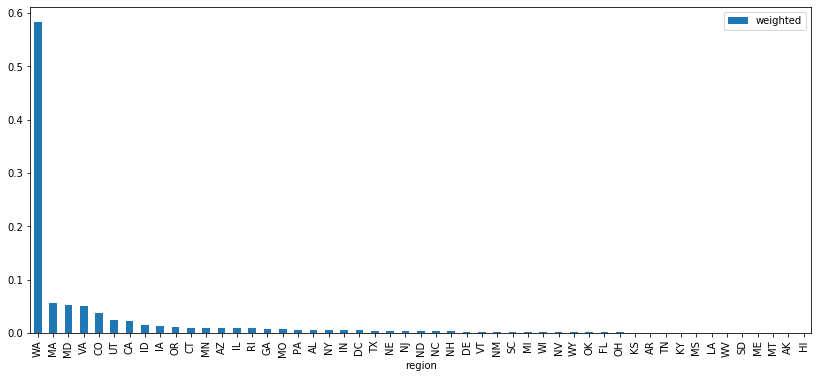

In [65]:
test = 'software engineer'

fig, ax = plt.subplots(figsize=(14,6))
temp = pd.DataFrame({'weighted': pipe.predict_proba([test])[0], 'region': pipe.named_steps['nb'].classes_})
temp.set_index('region', inplace=True)
temp.sort_values('weighted', ascending=False).plot.bar(ax=ax)

In [64]:
with open('models/sample_tfidf.pkd', 'wb') as file:
    dill.dump(tfv, file)
with open('models/sample_nb.pkd', 'wb') as file:
    dill.dump(model, file)
with open('models/sample_pipeline', 'wb') as file:
    dill.dump(pipe, file)

## Multinominal Naive-Bayes

In [71]:
with open('models/top_tfidf.pkd', 'rb') as file:
    tfv = dill.load(file)
    
ignore = pd.read_feather('other_data/ignore.feather')
ignore_dict = ignore.set_index('regex').to_dict()['sub']

folder = 'cleaned_cache'
files = [os.path.join(folder, 'data_{}.feather'.format(i)) for i in range(len(os.listdir(folder)))]

classes = pd.read_feather('other_data/us_states.feather', columns=['Abrv'])['Abrv']

weights = pd.read_feather('other_data/census.feather', columns=['region', 'weight'])
weights.set_index('region', inplace=True)
weights.sort_index(inplace=True)
weights = weights['weight'].tolist()

### without weights

In [5]:
nb = MultinomialNB(alpha=1)

nb = train_model(files, transformer=tfv, estimator=nb, classes=classes)

In [8]:
pipe = Pipeline([('clean', TextPreProcess(ignore=ignore_dict)), ('tfidf', tfv), ('nb', nb)])

In [10]:
with open('models/mnb_unweighted/nb.pkd', 'wb') as file:
    dill.dump(nb, file)
with open('models/mnb_unweighted/pipeline.pkd', 'wb') as file:
    dill.dump(pipe, file)

In [77]:
with open('models/mnb_unweighted/pipeline.pkd', 'rb') as file:
    all_pipe = dill.load(file)

### with weights

In [73]:
nb = MultinomialNB(alpha=1, class_prior=weights)

nb = train_model(files, transformer=tfv, estimator=nb, classes=classes)

In [74]:
per_capita_pipe = Pipeline([('clean', TextPreProcess(ignore=ignore_dict)), ('tfidf', tfv), ('nb', nb)])

In [75]:
with open('models/per_capita_nb.pkd', 'wb') as file:
    dill.dump(nb, file)
with open('models/per_capita_pipeline.pkd', 'wb') as file:
    dill.dump(pipe, file)

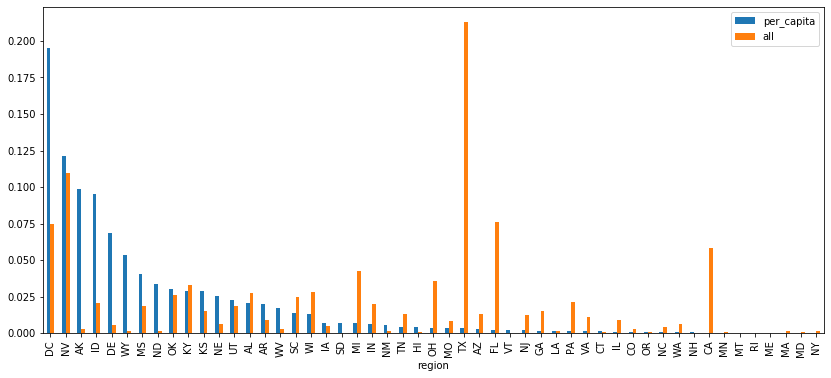

In [85]:
test = 'registered nurse'

fig, ax = plt.subplots(figsize=(14,6))
temp = pd.DataFrame({'per_capita': per_capita_pipe.predict_proba([test])[0], 'all': all_pipe.predict_proba([test])[0], 'region': pipe.named_steps['nb'].classes_})
temp.set_index('region', inplace=True)
temp.sort_values('per_capita', ascending=False).plot.bar(ax=ax)